## Before you start, Requirements
*   imageio
*   matplotlib
*   numpy
*   torch
*   torchvision

## Dataset: SineData

In [50]:
import glob
import numpy as np
import torch
from math import pi
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


class SineData(Dataset):
    """
    Dataset of functions f(x) = a * sin(x - b) where a and b are randomly
    sampled. The function is evaluated from -pi to pi.

    Parameters
    ----------
    amplitude_range : tuple of float
        Defines the range from which the amplitude (i.e. a) of the sine function
        is sampled.

    shift_range : tuple of float
        Defines the range from which the shift (i.e. b) of the sine function is
        sampled.

    num_samples : int
        Number of samples of the function contained in dataset.

    num_points : int
        Number of points at which to evaluate f(x) for x in [-pi, pi].
    """
    def __init__(self, amplitude_range=(-1., 1.), shift_range=(-.5, .5),
                 num_samples=1000, num_points=100):
        self.amplitude_range = amplitude_range
        self.shift_range = shift_range
        self.num_samples = num_samples
        self.num_points = num_points
        self.x_dim = 1  # x and y dim are fixed for this dataset.
        self.y_dim = 1

        # Generate data
        self.data = []
        a_min, a_max = amplitude_range
        b_min, b_max = shift_range
        for i in range(num_samples):
            # Sample random amplitude
            a = (a_max - a_min) * np.random.rand() + a_min
            # Sample random shift
            b = (b_max - b_min) * np.random.rand() + b_min
            # Shape (num_points, x_dim)
            x = torch.linspace(-pi, pi, num_points).unsqueeze(1)
            # Shape (num_points, y_dim)
            y = a * torch.sin(x - b)
            self.data.append((x, y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples

## Utils

In [51]:
import numpy as np
import torch


def context_target_split(x, y, num_context, num_extra_target):
    """Given inputs x and their value y, return random subsets of points for
    context and target. Note that following conventions from "Empirical
    Evaluation of Neural Process Objectives" the context points are chosen as a
    subset of the target points.

    Parameters
    ----------
    x : torch.Tensor
        Shape (batch_size, num_points, x_dim)

    y : torch.Tensor
        Shape (batch_size, num_points, y_dim)

    num_context : int
        Number of context points.

    num_extra_target : int
        Number of additional target points.
    """
    num_points = x.shape[1]
    # Sample locations of context and target points
    locations = np.random.choice(num_points,
                                 size=num_context + num_extra_target,
                                 replace=False)
    x_context = x[:, locations[:num_context], :]
    y_context = y[:, locations[:num_context], :]
    x_target = x[:, locations, :]
    y_target = y[:, locations, :]
    return x_context, y_context, x_target, y_target

## Encoder, Decoder

In [52]:
import torch
from torch import nn
from torch.nn import functional as F


class Encoder(nn.Module):
    """Maps an (x_i, y_i) pair to a representation r_i.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    h_dim : int
        Dimension of hidden layer.

    r_dim : int
        Dimension of output representation r.
    """
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(Encoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)

    def forward(self, x, y):
        """
        x : torch.Tensor
            Shape (batch_size, x_dim)

        y : torch.Tensor
            Shape (batch_size, y_dim)
        """
        input_pairs = torch.cat((x, y), dim=1)
        return self.input_to_hidden(input_pairs)


class MuSigmaEncoder(nn.Module):
    """
    Maps a representation r to mu and sigma which will define the normal
    distribution from which we sample the latent variable z.

    Parameters
    ----------
    r_dim : int
        Dimension of output representation r.

    z_dim : int
        Dimension of latent variable z.
    """
    def __init__(self, r_dim, z_dim):
        super(MuSigmaEncoder, self).__init__()

        self.r_dim = r_dim
        self.z_dim = z_dim

        self.r_to_hidden = nn.Linear(r_dim, r_dim)
        self.hidden_to_mu = nn.Linear(r_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(r_dim, z_dim)

    def forward(self, r):
        """
        r : torch.Tensor
            Shape (batch_size, r_dim)
        """
        hidden = torch.relu(self.r_to_hidden(r))
        mu = self.hidden_to_mu(hidden)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden))
        return mu, sigma


class Decoder(nn.Module):
    """
    Maps target input x_target and samples z (encoding information about the
    context points) to predictions y_target.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer.

    y_dim : int
        Dimension of y values.
    """
    def __init__(self, x_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, z):
        """
        x : torch.Tensor
            Shape (batch_size, num_points, x_dim)

        z : torch.Tensor
            Shape (batch_size, z_dim)

        Returns
        -------
        Returns mu and sigma for output distribution. Both have shape
        (batch_size, num_points, y_dim).
        """
        batch_size, num_points, _ = x.size()
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)
        # Input is concatenation of z with every row of x
        input_pairs = torch.cat((x_flat, z_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)
        # Reshape output into expected shape
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
        return mu, sigma


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process

In [54]:
import torch
from torch import nn
from torch.distributions import Normal


class NeuralProcess(nn.Module):
    """
    Implements Neural Process for functions of arbitrary dimensions.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    r_dim : int
        Dimension of output representation r.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer in encoder and decoder.
    """
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(NeuralProcess, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = Encoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = MuSigmaEncoder(r_dim, z_dim)
        self.xz_to_y = Decoder(x_dim, z_dim, h_dim, y_dim)

    def aggregate(self, r_i):
        """
        Aggregates representations for every (x_i, y_i) pair into a single
        representation.

        Parameters
        ----------
        r_i : torch.Tensor
            Shape (batch_size, num_points, r_dim)
        """
        return torch.mean(r_i, dim=1)

    def xy_to_mu_sigma(self, x, y):
        """
        Maps (x, y) pairs into the mu and sigma parameters defining the normal
        distribution of the latent variables z.

        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, num_points, x_dim)

        y : torch.Tensor
            Shape (batch_size, num_points, y_dim)
        """
        batch_size, num_points, _ = x.size()
        # Flatten tensors, as encoder expects one dimensional inputs
        x_flat = x.view(batch_size * num_points, self.x_dim)
        y_flat = y.contiguous().view(batch_size * num_points, self.y_dim)
        # Encode each point into a representation r_i
        r_i_flat = self.xy_to_r(x_flat, y_flat)
        # Reshape tensors into batches
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)
        # Aggregate representations r_i into a single representation r
        r = self.aggregate(r_i)
        # Return parameters of distribution
        return self.r_to_mu_sigma(r)

    def forward(self, x_context, y_context, x_target, y_target=None):
        """
        Given context pairs (x_context, y_context) and target points x_target,
        returns a distribution over target points y_target.

        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim). Note that x_context is a
            subset of x_target.

        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)

        y_target : torch.Tensor or None
            Shape (batch_size, num_target, y_dim). Only used during training.

        Note
        ----
        We follow the convention given in "Empirical Evaluation of Neural
        Process Objectives" where context is a subset of target points. This was
        shown to work best empirically.
        """
        # Infer quantities from tensor dimensions
        batch_size, num_context, x_dim = x_context.size()
        _, num_target, _ = x_target.size()
        _, _, y_dim = y_context.size()

        if self.training:
            # Encode target and context (context needs to be encoded to
            # calculate kl term)
            mu_target, sigma_target = self.xy_to_mu_sigma(x_target, y_target)
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            # Sample from encoded distribution using reparameterization trick
            q_target = Normal(mu_target, sigma_target)
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_target.rsample()
            # Get parameters of output distribution
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred, q_target, q_context
        else:
            # At testing time, encode only context
            mu_context, sigma_context = self.xy_to_mu_sigma(x_context, y_context)
            # Sample from distribution based on context
            q_context = Normal(mu_context, sigma_context)
            z_sample = q_context.rsample()
            # Predict target points based on context
            y_pred_mu, y_pred_sigma = self.xz_to_y(x_target, z_sample)
            p_y_pred = Normal(y_pred_mu, y_pred_sigma)

            return p_y_pred


## Neural Process

In [55]:
import torch
from random import randint
from torch import nn
from torch.distributions.kl import kl_divergence


class NeuralProcessTrainer():
    """
    Class to handle training of Neural Processes for functions and images.

    Parameters
    ----------
    device : torch.device

    neural_process : neural_process.NeuralProcess or NeuralProcessImg instance

    optimizer : one of torch.optim optimizers

    num_context_range : tuple of ints
        Number of context points will be sampled uniformly in the range given
        by num_context_range.

    num_extra_target_range : tuple of ints
        Number of extra target points (as we always include context points in
        target points, i.e. context points are a subset of target points) will
        be sampled uniformly in the range given by num_extra_target_range.

    print_freq : int
        Frequency with which to print loss information during training.
    """
    def __init__(self, device, neural_process, optimizer, num_context_range,
                 num_extra_target_range, print_freq=100):
        self.device = device
        self.neural_process = neural_process
        self.optimizer = optimizer
        self.num_context_range = num_context_range
        self.num_extra_target_range = num_extra_target_range
        self.print_freq = print_freq

        # Check if neural process is for images
        self.is_img = False
        self.steps = 0
        self.epoch_loss_history = []

    def train(self, data_loader, epochs):
        """
        Trains Neural Process.

        Parameters
        ----------
        dataloader : torch.utils.DataLoader instance

        epochs : int
            Number of epochs to train for.
        """
        for epoch in range(epochs):
            epoch_loss = 0.
            for i, data in enumerate(data_loader):
                self.optimizer.zero_grad()

                # Sample number of context and target points
                num_context = randint(*self.num_context_range)
                num_extra_target = randint(*self.num_extra_target_range)

                # Create context and target points and apply neural process
                x, y = data
                x_context, y_context, x_target, y_target = \
                    context_target_split(x, y, num_context, num_extra_target)
                p_y_pred, q_target, q_context = \
                    self.neural_process(x_context, y_context, x_target, y_target)

                loss = self._loss(p_y_pred, y_target, q_target, q_context)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                self.steps += 1

                if self.steps % self.print_freq == 0:
                    print("iteration {}, loss {:.3f}".format(self.steps, loss.item()))

            print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(data_loader)))
            self.epoch_loss_history.append(epoch_loss / len(data_loader))

    def _loss(self, p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl


## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

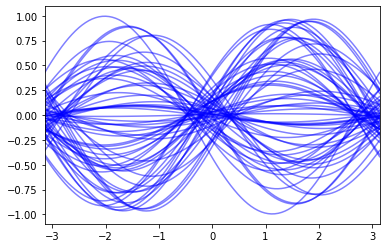

In [56]:
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [57]:
x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

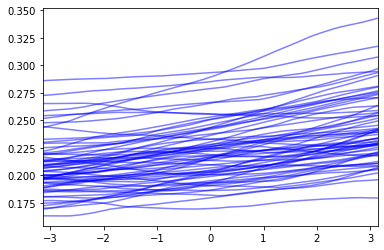

In [58]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [59]:
batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 3.746
iteration 400, loss 0.350
iteration 600, loss 4.528
iteration 800, loss 3.728
iteration 1000, loss -2.961
Epoch: 0, Avg_loss: 4.0179700414137915
iteration 1200, loss 6.560
iteration 1400, loss 1.037
iteration 1600, loss 6.227
iteration 1800, loss 5.383
iteration 2000, loss -0.583
Epoch: 1, Avg_loss: 1.9446451769582926
iteration 2200, loss -5.157
iteration 2400, loss 1.499
iteration 2600, loss 7.306
iteration 2800, loss -2.900
iteration 3000, loss 2.630
Epoch: 2, Avg_loss: 1.7283769601471721
iteration 3200, loss 3.706
iteration 3400, loss 7.312
iteration 3600, loss 8.118
iteration 3800, loss -3.370
iteration 4000, loss 9.992
Epoch: 3, Avg_loss: 1.654508279182017
iteration 4200, loss -0.774
iteration 4400, loss 6.377
iteration 4600, loss -7.524
iteration 4800, loss 1.971
iteration 5000, loss 6.519
Epoch: 4, Avg_loss: 1.6185235176756978
iteration 5200, loss 2.917
iteration 5400, loss 3.906
iteration 5600, loss 5.144
iteration 5800, loss 2.093
iteration 6000, loss

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

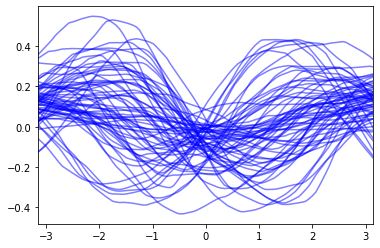

In [60]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

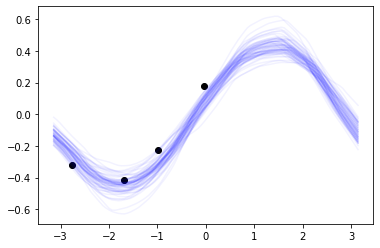

In [61]:
# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')